# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*

**Estimated time:** XX mins presenting + YY mins exercises

## Chapter 3: Image Processing (part 2)

### Two experiments

#### Tracking a kinase translocation reporter (KTR)

To assess the activity of kinases in single live cells, which can e.g. activate and deactivate proteins, researchers have developed kinase translocation reporters (KTRs). These are fluorescently tagged proteins (or protein domain) whose location inside the cell changes (translocates) depending on whether a specific kinase is active (see also figure 1 of [Kudo et al.](http://doi.org/10.1038/nprot.2017.128)).

The paper [Chavez-Abiega et al.](http://doi.org/10.1242/jcs.259685) presents an image analysis pipeline to analyze KTR signals from single cells (and uses it to study kinase behavior). We'll use their data, and try to reproduce part of that analysis.

<img src=images/figures/kudo_fig1b.png height=200>

*Fig 1b of Kudo et al., When kinase activity is high, KTRs predominantly localize to the cytoplasm due to reduced nuclear localization signal and increased nuclear export signal.*

#### Quantifying bacterial size

In the paper by [Wehrens et al.](http://doi.org/10.1016/j.cub.2018.02.006) the authors quantify how stressed *E. coli* become oddly long shaped, and moreover how, after stress receeded, they recover their familiar rod-shaped sizes.

<img src=images/figures/wehrens_GA.jpg height=100>

We'll also try to reproduce (a very small part) of their analysis.

### Loading the data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
import numpy as np

# some new ones
import skimage as sk
from scipy import stats
from scipy import ndimage

# something convenient for later
FIGSIZE21 = (10/2.54,5/2.54) 
FIGSIZE22 = (10/2.54,10/2.54) 

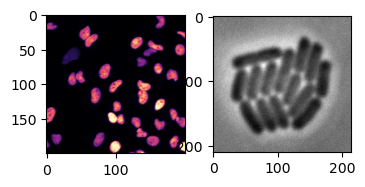

In [4]:

# Load part of the KTR data (Chavez-Abiega et al.)
img_path_KTR = '/Users/m.wehrens/Data_notbacked/2025_Py-Image-workshop_KTR-example-data/raw/Composite_KTR.tif'
img_nuclei = tiff.imread(img_path_KTR)[0, 0, 0:200, 0:200]

# Let's also load an image of some bacteria (Wehrens et al.)
path_img_ecoli = 'images/biological/microcolony_ecoli.tif'
img_ecoli = tiff.imread(path_img_ecoli)
# invert image
img_ecoli_inv = np.max(img_ecoli)-img_ecoli

# Display the images
fig, axs = plt.subplots(1,2, figsize=FIGSIZE21)
_ = axs[0].imshow(img_nuclei, cmap='magma')
_ = axs[1].imshow(img_ecoli, cmap='gray')
plt.show()

## Step 1: segmentation

- We aim to quantify 
    - **nuclear vs. cytoplasmic signal** in the KTR dataset, 
    - and **bacterial sizes** the bacterial dataset. 
- To achieve both, we first need to **segment** both **nuclei** and **bacteria**.
- Global **manual thresholds** are **labor intensive and subjective**. Let's try to do this automatically.

### Background information

#### Different types of challenges

- Generally, the segmentation approach depends on type of data.
- Global thresholds are based on statistics visualized well by histograms.

<br>

<img src="images/figures/biobook_fig68.png" width=75%>

*Image taken from [biobook](https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html) (fig. 68).*

## Automated global thresholds

#### Otsu's method

Otsu’s method, introduced in 1979, has become an extremely popular approach to determining a threshold. It’s commonly described, somewhat intimidatingly, as ‘minimizing the intra-class intensity variance’. In essence, calculating a threshold using Otsu’s method involves adding the variance of the background pixels to the variance of the foreground pixels, for all possible thresholds. The threshold that is selected is the one for which the sum of the variances is smallest.

*Source: [biobook](https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html).*

#### More thresholding-finding algorithms

Other methods include:
- Threshold determined by estimate of background
- Triangle method
- Yen method
- (..)

**A list can be found at** [scikit image's documentation](https://scikit-image.org/docs/0.23.x/auto_examples/segmentation/plot_thresholding.html).

### Applying automatic thresholding

In [30]:
def my_plot_12(img1, img2, mycmap='viridis'):
    # plot two images side by side
    fig, axs = plt.subplots(1,2, figsize=FIGSIZE21)
    _ = axs[0].imshow(img1, cmap=mycmap)
    _ = axs[1].imshow(img2, cmap=mycmap)  
    plt.tight_layout()  

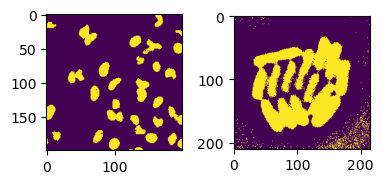

In [31]:
# Let's try some of these thresholding approaches

# The Otsu method
mask_nuclei_otsu = img_nuclei > sk.filters.threshold_otsu(img_nuclei)
mask_ecoli_otsu = img_ecoli_inv > sk.filters.threshold_otsu(img_ecoli_inv)
my_plot_12(mask_nuclei_otsu, mask_ecoli_otsu)


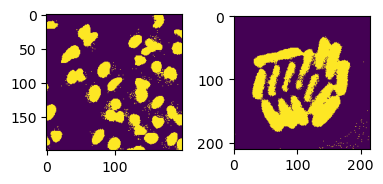

In [32]:

# The Triangle method
mask_nuclei_triangle = img_nuclei > sk.filters.threshold_triangle(img_nuclei)
mask_ecoli_triangle = img_ecoli_inv > sk.filters.threshold_triangle(img_ecoli_inv)
my_plot_12(mask_nuclei_triangle, mask_ecoli_triangle)


## Morphological operations

### Neighborhoods and convolutions

Segmenting the bacteria are 
- too big of a **challenge** to tackle with global thresholding. 
- That's because there are **local differences** within the image.

We need to process the image locally.

#### Convolution

We'll briefly dive into convolutions, which will hopefully help you understand neighborhood operations, which are fundamental in image processing.

<img src=images/figures/pytorch_convolution.jpeg width=40%>

*Image via [discuss.pytorch.org](https://discuss.pytorch.org/t/deformable-convolution-layer-with-variable-filter/58799). In convolution, a new image is created by for each pixel summing its neighborhood pixels multiplied with neighborhood location specific weights.*

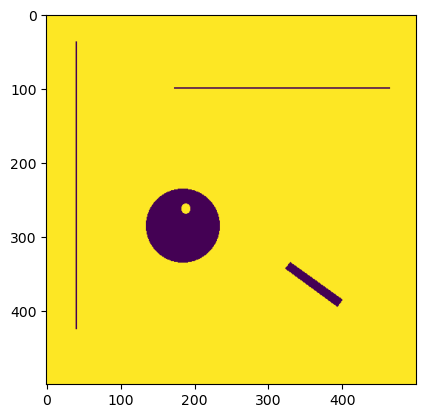

In [33]:
# Let's illustrate this concept with some examples

# Load an example picture
img_pika = tiff.imread('images/misc/pikachu.tif')
_= plt.imshow(img_pika)

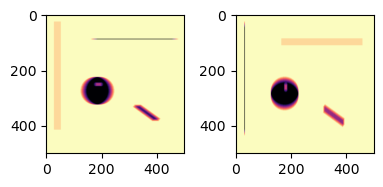

In [37]:

# Define a horizontal line "kernel"
kernel_h = np.zeros((25,25))
kernel_h[2,:] = 12
kernel_h=kernel_h/np.sum(kernel_h)

# Define a vertical line "kernel"
kernel_v = np.zeros((25,25))
kernel_v[:,2] = 12
kernel_v=kernel_v/np.sum(kernel_v)

# Apply them both to the image
img_pika_h = ndimage.convolve(img_pika, kernel_h)
img_pika_v = ndimage.convolve(img_pika, kernel_v)

# Now show both pictures
my_plot_12(img_pika_h, img_pika_v, mycmap='magma')

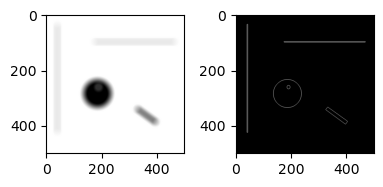

In [47]:


# Define a disk kernel
kernel_disk = sk.morphology.disk(15) 
kernel_disk = kernel_disk/np.sum(kernel_disk)

# Define an edge kernel
kernel_laplacian = np.array([[0, -1,  0],
                      [-1,  4, -1],
                      [0, -1,  0]])

# Now apply and plot
img_pika_disk = ndimage.convolve(img_pika, kernel_disk)
img_pika_edge = ndimage.convolve(img_pika, kernel_laplacian)
my_plot_12(img_pika_disk, img_pika_edge, mycmap='gray')

## Dilution and erosion

- We can go a step further
    - **Dilation and erosion** are very useful operations

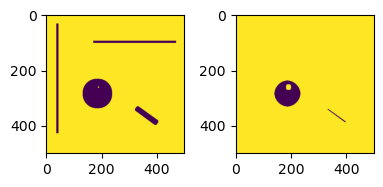

In [52]:
# Perform dilation and erosion on pika image
img_pika_eroded  = sk.morphology.erosion(img_pika, footprint=np.ones((7,7)))
img_pika_dilated = sk.morphology.dilation(img_pika, footprint=np.ones((7,7)))
# Show 'm
my_plot_12(img_pika_eroded, img_pika_dilated, mycmap='viridis')

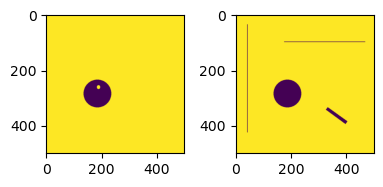

In [ ]:
# They can also be combined
# Morphological closing (dilation followed by erosion)
img_pika_closed = sk.morphology.closing(img_pika, footprint=sk.morphology.disk(7))
# Morphological opening (erosion followed by dilation)
img_pika_opened = sk.morphology.opening(img_pika, footprint=sk.morphology.disk(7))

# Show the result
my_plot_12(img_pika_closed, img_pika_opened, mycmap='viridis')

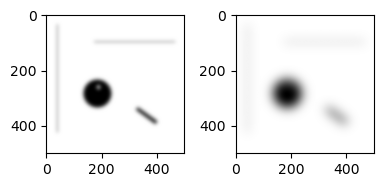

In [58]:
# Blurring can also be done more sophisticated
img_pika_gauss07 = sk.filters.gaussian(img_pika, sigma=7)
img_pika_gauss20 = sk.filters.gaussian(img_pika, sigma=20)

# Now show both
my_plot_12(img_pika_gauss07, img_pika_gauss20, mycmap='gray')


## Combining everything

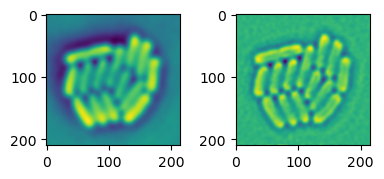

In [61]:
# Now these can also be combined
# E.g. bacterial segmentation
    # we're interested in local edge detection

# Show the results of LoG on the bacteria
img_ecoli_gauss = sk.filters.gaussian(img_ecoli_inv, sigma=3)
edges_log = sk.filters.laplace(img_ecoli_gauss)
# show both
my_plot_12(img_ecoli_gauss, edges_log, mycmap='viridis')


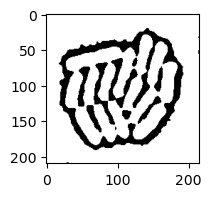

In [83]:

def my_plot_1(img1, mycmap='gray', myfigsize=(5/2.54,5/2.54)):
    fig, ax = plt.subplots(1,1, figsize=myfigsize)
    _=plt.imshow(img1, cmap=mycmap)    

# Threshold edges_log by triangle method
mask_ecoli_log = edges_log > sk.filters.threshold_triangle(edges_log)
my_plot_1(mask_ecoli_log)

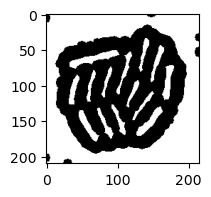

In [71]:
# Let's erode this by 5 px
mask_ecoli_log_eroded = sk.morphology.erosion(mask_ecoli_log, footprint=sk.morphology.disk(5))

# Show
my_plot_1(mask_ecoli_log_eroded)



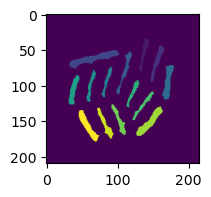

In [85]:
# Let's combine with our original triangle mask

# first remove small objects
mask_ecoli_triangle_filtered   = sk.morphology.remove_small_objects(mask_ecoli_triangle, min_size=50)
mask_ecoli_log_eroded_filtered = sk.morphology.remove_small_objects(mask_ecoli_log_eroded, min_size=50)

# Combine
mask_bacteria_slim = np.logical_and(mask_ecoli_triangle_filtered, mask_ecoli_log_eroded)
# And label
mask_bacteria_slim_labeled = sk.measure.label(mask_bacteria_slim)
my_plot_1(mask_bacteria_slim_labeled, mycmap='viridis')


## Watershed

<img src=images/misc/puddles.png height=200px>
<img src=images/misc/watershed.jpg height=200px>

*(Pictures via user24124133 and [researchgate](http://dx.doi.org/10.3390/rs6010776).)  Watershed is a common algorithm to segment touching objects. It is inspired by how water would fill up a landscape. From specific seeds, the water level rises, and once separate regions touch, boundaries are established.*

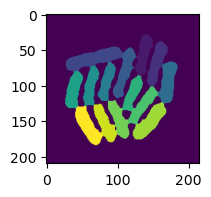

In [87]:
# This is a great tool to separate one of earlier bacterial images.
# Apply watershed to mask_ecoli_log, using mask_bacteria_slim_labeled as seeds
mask_bacteria_combined = sk.segmentation.watershed(-edges_log, markers=mask_bacteria_slim_labeled, mask=mask_ecoli_log)

# Show the result
my_plot_1(mask_bacteria_combined, mycmap='viridis')

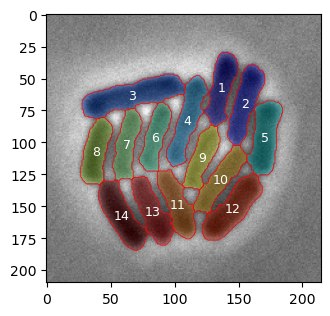

In [100]:
# Polish the final image a little bit

# Let's get regionprops from mask_bacteria_combined
props = sk.measure.regionprops(mask_bacteria_combined)

# Plot it
fig, ax = plt.subplots(1,1, figsize=(9/2.54,9/2.54))
_ = ax.imshow(img_ecoli, cmap='gray')
# slightly shaded region
plt.imshow(mask_bacteria_combined, cmap='jet', alpha= .3*(mask_bacteria_combined>0))
# project numbered labels on top
for x,y,lbl in [(p.centroid[1], p.centroid[0], p.label) for p in props]:
    # centered text
    ax.text(x, y, str(lbl), color='white', fontsize=9, ha='center', va='center')
    # specific bacterial outline
    ax.contour(mask_bacteria_combined==lbl, colors='red', linewidths=0.5)
    

## Exercises

- Write a function that segments a picture of bacteria, e.g. `seg_bacterium(input_img)`.
    - Test that it works.
    - Remember that pixels were 0.041 um wide. An average bacterium is ~1-2 μm long and .5-1 μm wide. Are bacterial sizes we observe consistent with this?
- Write a function to segment a picture of nuclei, e.g. `seg_nuclei(input_img)`.
    - Test that it works.
    
## Additional exercises

- Look up what a 'distance transform' is (`scipy.ndimage.distance_transform_edt`) and apply it to the nuclei image. 
    - Create a mask based on thresholding the distance transform.
        - To achieve this, use the function `sk.feature.peak_local_max()`.    

- Load the image `chatGPT_shadybusiness_licensehigh-8bit.tif`. 
    - Try to segment the symbols on the license plate.
    - Use `regionprops` and `bbox` to plot each symbol separately.